# Notebook Jobs - end to end demo

## SQL Friday #87 - Lightning Talk Friday!!

May 27 2022

**<u>Abstract</u>**

As database professionals, we all know how to manage SQL Server Agent jobs using SQL Server Management Studio (SSMS), TSQL, and PowerShell. With Azure Data Studio and SQL Server Agent extension, we have new tools to create, maintain and manage SQL Agent jobs using Notebook. These are called Notebook Jobs. Once you successfully execute a Notebook job manually or via schedule, each run's results are saved into a separate Notebook, which you can easily share with others.

In this 100% demo session, I will walk you through every step of Notebook Jobs.

## Pre-requisite

- Create a Notebook that you want to run as a job
- Enable **SQL Server Agent**  or **Admin Pack for SQL Server** Extension
- Pre-create an agent job schedule
- Select a database to save metadata

### Step1: Creating an empty database to hold Notebook jobs metadata and execution details

You can use any existing database too

Two tables get created when you use the database to store metadata :

1. nb\_template - Stores the Notebook definition
2. nb\_materialized - Stores the result for each run

In [ ]:
USE [master];
GO

-- drop database if exists
DROP DATABASE IF EXISTS Notebookjobs;
GO

-- create database notebookjobs
CREATE DATABASE Notebookjobs;
GO

### Step2: Creating a Notebook Job

### Copied from : [Scheduling SQL Notebooks in Azure Data Studio](https://www.sqlshack.com/scheduling-sql-notebooks-in-azure-data-studio/)

### It requires the following details.

- **Notebook Path:** In this column, specify the path of the SQL notebook that we wish to schedule
- **Storage database:** As you know, SQL agent job stores in the MSDB system database. For a notebook, we can choose the storage database of the job. The notebook is a JSON format file so we can store it in any database. It creates two tables in the storage database for storing template and execution results. We will look at this later once configured the notebook job
- **Execution database:** It is the database content under which the query will execute. It can be the same database we specified in the storage database
- **Job details:** Specify a name for the SQL notebook job
- **Owner:** It is the job owner. By default, It takes the account by which we connected to SQL instance. This account should have permission to execute the query specified in the notebook
- **Schedule:** We can pick a schedule that already exists for the SQL Server agent job. Right-now, it does not allow configuring a new schedule in Azure Data Studio. We need to switch to SQL Server Management Studio for it

In [ ]:
-- Drop the job if exist as we will create a job with Notebook
-- Notebook jobs pick Notebook name as Job name by default

USE [msdb]
GO

DECLARE @jobId binary(16)

SELECT @jobId = job_id FROM msdb.dbo.sysjobs WHERE (name = N'DatabaseConfiguration')
IF (@jobId IS NOT NULL)
BEGIN
    EXEC msdb.dbo.sp_delete_job @jobId
END

SELECT @jobId = job_id FROM msdb.dbo.sysjobs WHERE (name = N'DatabaseList')
IF (@jobId IS NOT NULL)
BEGIN
    EXEC msdb.dbo.sp_delete_job @jobId
END

### Step3: Run a Notebook Job

- Let the job run at scheduled time
- Run the job manully

### Step4: Look at output

**Output is saved here as a Notebook that you can share with others**

C:\\Users\\UserName\\AppData\\Local\\Temp\\mssql\_notebooks\\

### Step5: Look at metadata

In [ ]:
-- Notebook Jobs defination
USE [Notebookjobs];
GO
SELECT [template_id]
      ,[job_id]
      ,[notebook]
      ,[execute_database]
      ,[last_run_notebook_error]
  FROM [notebookjobs].[notebooks].[nb_template];
GO

-- Notebook Jobs execution history
USE [Notebookjobs];
GO
SELECT [materialized_id]
      ,[job_id]
      ,[run_time]
      ,[run_date]
      ,[notebook]
      ,[notebook_error]
      ,[pin]
      ,[is_deleted]
      ,[notebook_name]
  FROM [notebookjobs].[notebooks].[nb_materialized]
  ORDER BY run_date DESC, run_time DESC;
  GO

**You can also execute the Notebook using PowerShell command**

[Invoke-SqlNotebook](https://docs.microsoft.com/en-us/powershell/module/sqlserver/invoke-sqlnotebook?view=sqlserver-ps)

This solves two issues with Notebook Jobs

1. Run a notebook against SQL named instance
2. Run a notebood against Azure SQL database

```
# Running against default instance
Invoke-SqlNotebook -ServerInstance DESKTOP-50O69FS -Database master -InputFile "C:\Presentation\NotebookJobs\DatabaseConfiguration.ipynb" -Force|Open-EditorFile

# Running against named instance
Invoke-SqlNotebook -ServerInstance "DESKTOP-50O69FS\SQL2019" -Database master -InputFile "C:\Presentation\NotebookJobs\DatabaseList.ipynb" -Force|Open-EditorFile

# Running against Azure SQL database
Import-Module SQLServer
Import-Module Az.Accounts
Connect-AzAccount
Set-AzContext -SubscriptionId '18d92f52-ac34-4379-ab8b-5a5106f1c54e'
$password = Get-Content "C:\password.txt"
Invoke-SqlNotebook -ConnectionString "Server=tcp:dataexposed.database.windows.net,1433;Initial Catalog=master;Persist Security Info=False;User ID=taiob;Password=$password;MultipleActiveResultSets=False;Encrypt=True;TrustServerCertificate=False;Connection Timeout=30;" -InputFile "C:\Presentation\NotebookJobs\DatabaseList.ipynb" -Force|Open-EditorFile
```

## Reference
- [Use Jupyter Notebooks in Azure Data Studio](https://docs.microsoft.com/en-us/sql/azure-data-studio/notebooks/notebooks-guidance?view=sql-server-ver15)
- [Create and run a SQL Server notebook](https://docs.microsoft.com/en-us/sql/azure-data-studio/notebooks/notebooks-sql-kernel?view=sql-server-ver15)
- [SQL Server Agent extension (Preview)](https://docs.microsoft.com/en-us/sql/azure-data-studio/extensions/sql-server-agent-extension?view=sql-server-ver15)
- [Automate Your SQL Notebooks with Two New Options](https://sqlvariant.com/2019/09/automate-your-sql-notebooks-with-two-new-options/) by Aaron Nelson
- [Scheduling SQL Notebooks in Azure Data Studio](https://www.sqlshack.com/scheduling-sql-notebooks-in-azure-data-studio/) by Rajendra Gupta


## Contacts
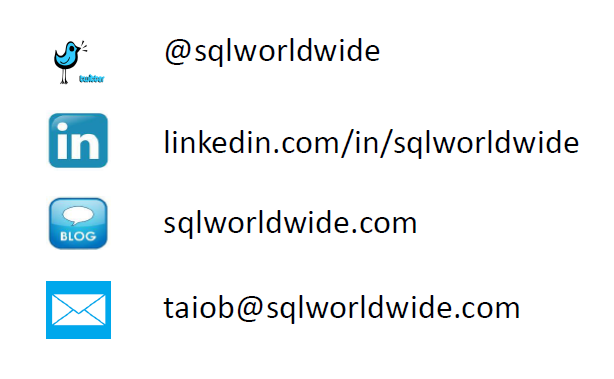